<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/6c_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocodificador variacional
En esta libreta programaremos un autocodificador variacional y lo aplicaremos al conjunto de imágenes de dígitos escritos a mano MNIST.

In [ ]:
from itertools import islice
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch as th
from torch import nn
from torch.optim import Adam

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T

N_EPOCAS = 100
T_LOTE = 128

np.random.seed(42)
th.manual_seed(42)

## Conjunto de datos

Se carga y preprocesan las imágenes del conjunto Fashion MNIST, escalando los valores de los pixeles de $[0,255]$ a $[-1, 1]$:

In [ ]:
tr_ent = T.Compose([T.ToTensor(),
                    T.Normalize(mean = [0.5],
                                std = [0.5])])
ent = MNIST(root='mnist',
            train=True,
            transform = tr_ent,
            download=True)

tr_prueba = T.Compose([T.ToTensor(),
                       T.Normalize(mean = [0.5],
                                   std = [0.5])])
prueba = MNIST(root='mnist',
               train=False,
               transform = tr_prueba,
               download=True)

Creamos nuestro cargador de datos

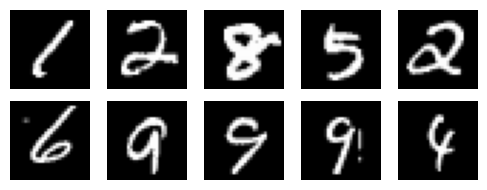

In [ ]:
entdl = DataLoader(ent,
                   batch_size = T_LOTE,
                   shuffle = True,
                   num_workers = 8)

fig = plt.figure(figsize=(5, 2))
for x,y in islice(entdl, 1):
  for i in range(10):
    img = np.floor(x[i].numpy().reshape(28, 28) * 127.5 + 127.5)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
fig.tight_layout()
plt.show()

## VAE con redes densas
Definimos nuestro codificador, decodificador y la VAE

In [ ]:
class Codificador(nn.Module):
  def __init__(self, d):
    super(Codificador, self).__init__()
    self.densa_entrada = nn.Sequential(nn.Linear(d, 400),
                                       nn.LeakyReLU(),
                                       nn.Linear(400, 150),
                                       nn.LeakyReLU())
    self.densa_mu = nn.Linear(150, 50)
    self.densa_logvar = nn.Linear(150, 50)


  def forward(self, x):
    h = self.densa_entrada(x)
    mu = self.densa_mu(h)
    logvar = self.densa_logvar(h)
    return mu, logvar

class Decodificador(nn.Module):
  def __init__(self, d):
    super(Decodificador, self).__init__()
    self.red_densa = nn.Sequential(nn.Linear(50, 150),
                                   nn.LeakyReLU(),
                                   nn.Linear(150, 400),
                                   nn.LeakyReLU(),
                                   nn.Linear(400, d),
                                   nn.Tanh())

  def forward(self, z):
    x = self.red_densa(z)
    return x

class VAE(nn.Module):
  def __init__(self, d):
    super(VAE, self).__init__()
    self.cod = Codificador(d)
    self.dec = Decodificador(d)

  def proyectar(self, x):
    mu, logvar = self.cod(x)
    std = th.exp(0.5 * logvar)
    eps = th.randn_like(std)
    z = mu + eps * std
    return z

  def forward(self, x):
    mu, logvar = self.cod(x)
    std = th.exp(0.5 * logvar)
    eps = th.randn_like(std)
    z = mu + eps * std
    xrec = self.dec(z)
    return xrec, mu, logvar

La función de pérdida es la suma del error cuadrático medio y la divergencia KL

In [ ]:
def funcion_perdida(x, xrec, mu, logvar):
  ecm = nn.functional.mse_loss(x, xrec, reduction='sum')
  kl = -0.5 * th.sum(1 + logvar - mu**2 - logvar.exp())
  perdida = ecm + kl
  return perdida

Creamos una función para entrenar nuestro VAE

In [ ]:
def paso_ent(x,
             modelo,
             opt,
             fp):

  xrec, mu, logvar = vae(x)
  p = fp(xrec, x, mu, logvar)

  opt.zero_grad()
  p.backward()
  opt.step()

  return p.item()

def entrena(modelo,
            opt,
            disp,
            fp,
            n_epocas):

  perdidas = []
  for e in tqdm(range(n_epocas), desc = 'Época'):
    perdidas_epoca = []
    for x,y in entdl:
      x = x.to(disp).flatten(start_dim=1)
      p = paso_ent(x,
                   modelo,
                   opt,
                   fp)
      perdidas_epoca.append(p)

    perdidas.append(np.mean(perdidas_epoca))

  return modelo, perdidas

Instanciamos nuestra clase de autocodificador variacional y la movemos al GPU is está disponible

In [ ]:
disp = th.device('cuda' if th.cuda.is_available() else 'cpu')

vae = VAE(784)
vae = vae.to(disp)

Entrenamos el modelo

In [ ]:
opt = Adam(vae.parameters(), lr=1e-3)
vae, perdidas = entrena(vae,
                        opt,
                        disp,
                        funcion_perdida,
                        N_EPOCAS)

Época:   0%|          | 0/100 [00:00<?, ?it/s]

Graficamos las pérdidas

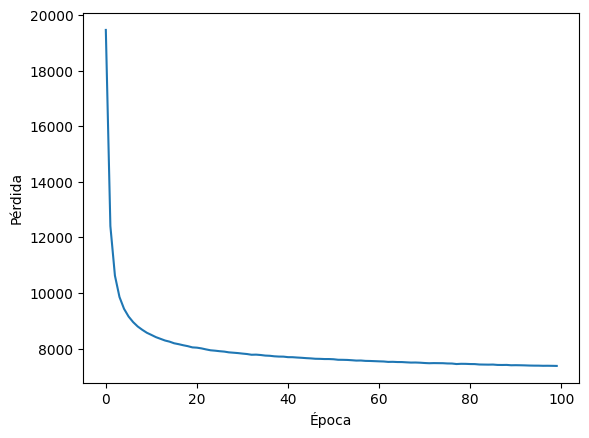

In [ ]:
plt.plot(perdidas)
plt.xlabel(u'Época')
plt.ylabel(u'Pérdida')
plt.show()

Definimos una función para desplegar muestras de imágenes generadas en una cuadrícula

In [ ]:
def visualiza_imagenes(xs,
                       n_filas = 10,
                       n_columnas = 10,
                       imshape = (28,28),
                       figsize = (10, 10)):
  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(n_filas, n_columnas)
  gs.update(wspace=0.05, hspace=0.05)
  for i in range(n_filas):
    for j in range(n_columnas):
      ax = plt.subplot(gs[i * n_filas + j])
      img = np.floor(xs[i * n_filas + j].reshape(imshape) * 127.5 + 127.5)
      ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
      ax.axis('off')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_aspect('equal')

## Regenerando imágenes de entrenamiento y validación
Pasamos el modelo entrenado al CPU para generar muestras de imágenes

In [ ]:
vae = vae.to('cpu')

Reconstruimos las imágenes de entrenamiento y visualizamos algunas muestras

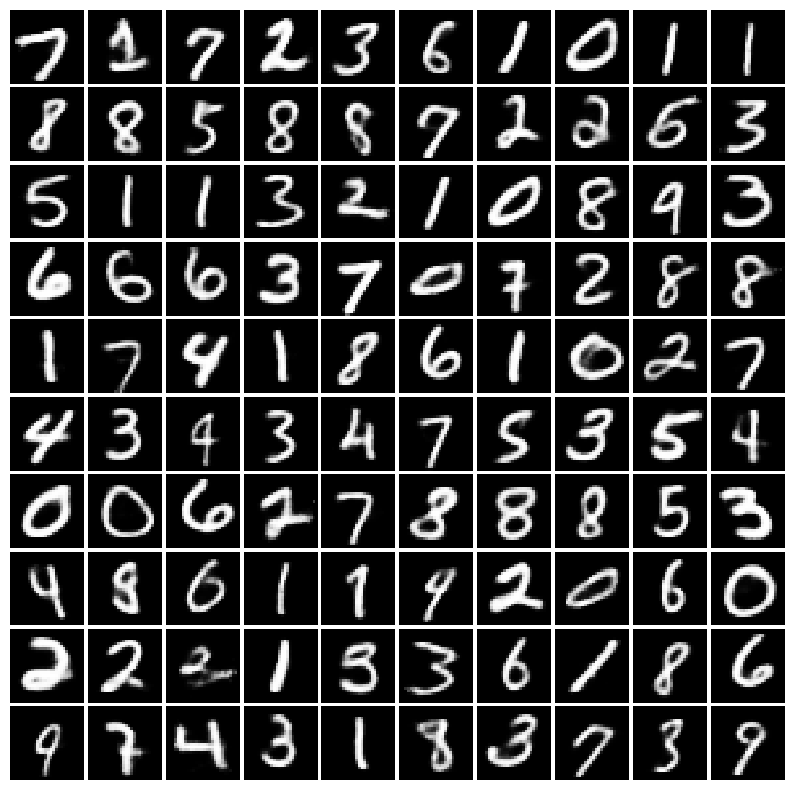

In [ ]:
it_ent = iter(entdl)
x,y = next(it_ent)

with th.no_grad():
  Xrec_ent, _, _ = vae(x.flatten(start_dim=1))

visualiza_imagenes(Xrec_ent.numpy())

Reconstruimos las imágenes de validación y visualizamos algunas muestras

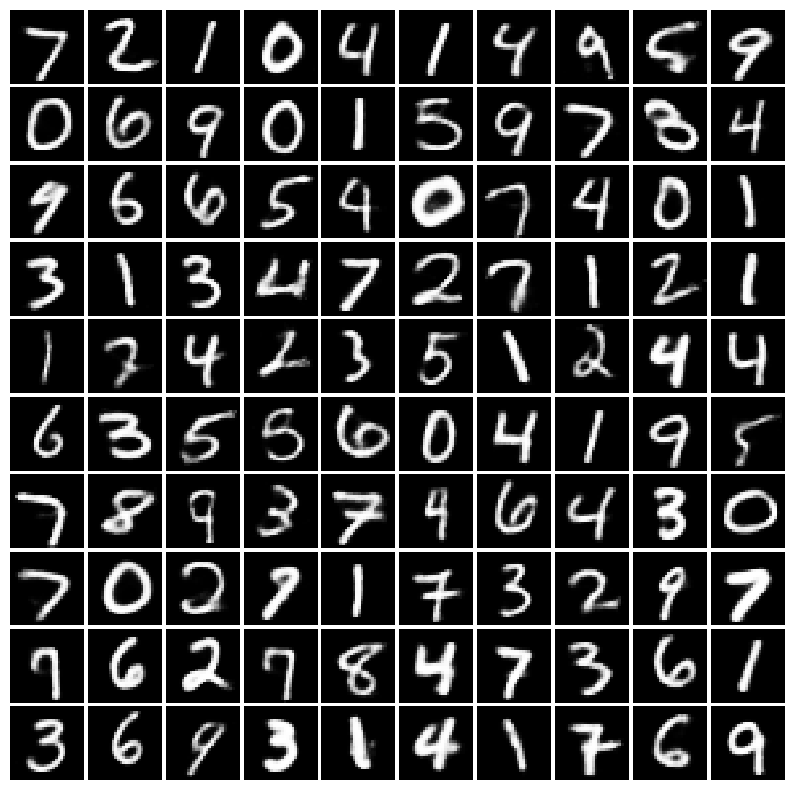

In [ ]:
pruebadl = DataLoader(prueba,
                      batch_size = len(prueba),
                      shuffle = False,
                      num_workers = 0)

it_prueba = iter(pruebadl)
x_prueba, y_prueba = next(it_prueba)

with th.no_grad():
  Xrec_prueba, _, _ = vae(x_prueba.flatten(start_dim=1))

visualiza_imagenes(Xrec_prueba.numpy())

## Generación de muestras aleatorias
Muestreamos vectores latentes $z\sim\mathcal{N}(0, \mathbb{I})$ y generamos imágenes a partir de estos

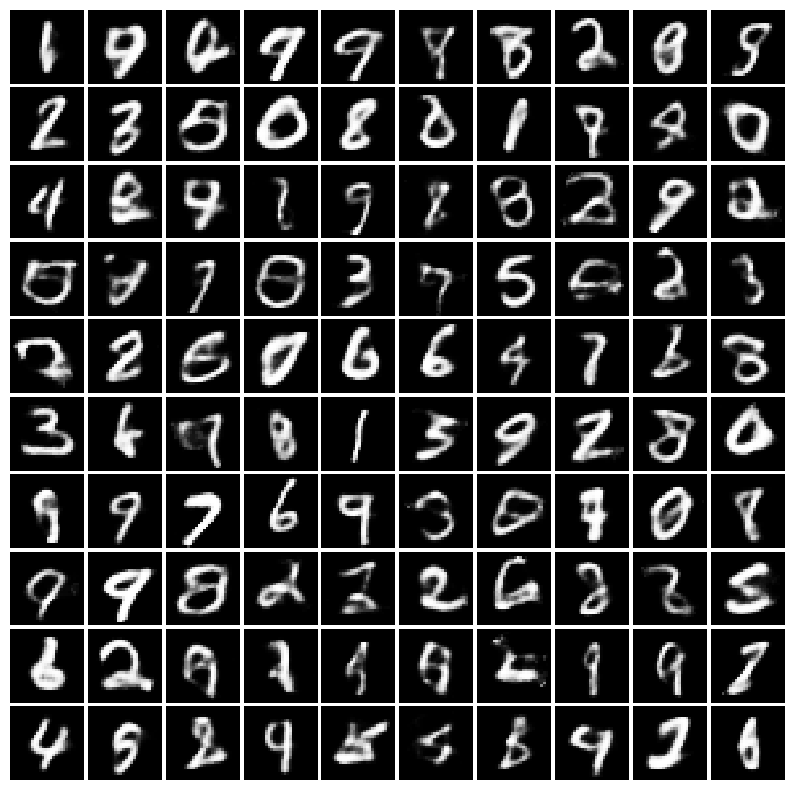

In [ ]:
z = th.randn((100, 50))

with th.no_grad():
  xrec = vae.dec(z)

visualiza_imagenes(xrec.numpy()[:100])

## Interpolación de dos vectores
Exploramos las imágenes generadas con los vectores interpolados entre los vectores latentes de dos dígitos dados

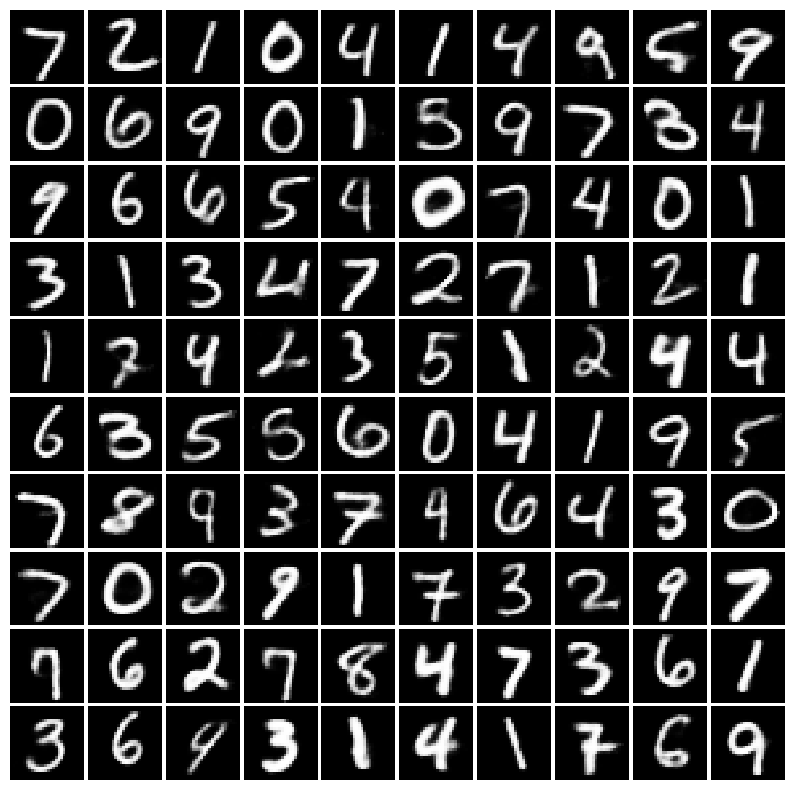

In [ ]:
with th.no_grad():
  z_prueba = vae.proyectar(x_prueba.flatten(start_dim = 1))
  Xrec_prueba = vae.dec(z_prueba)

visualiza_imagenes(Xrec_prueba.numpy())

Tomamos los vectores latentes de dos dígitos del conjunto de validación y obtenemos su vector latente

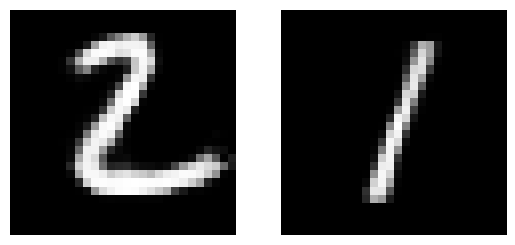

In [ ]:
with th.no_grad():
  x1 = vae.dec(z_prueba[1])
  x2 = vae.dec(z_prueba[2])

img1 = np.floor(x1.numpy().reshape(28, 28) * 127.5 + 127.5)
img2 = np.floor(x2.numpy().reshape(28, 28) * 127.5 + 127.5)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 2, 2)
ax.imshow(img2, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

Interpolamos vectores entre los vectores latentes de estos dos dígitos y generamos las imágenes de los vectores interpolados.

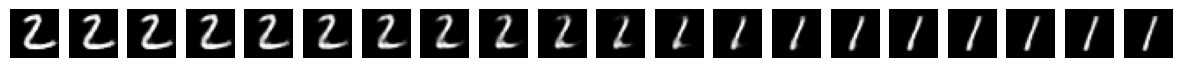

In [ ]:
vals = th.linspace(0, 1, steps=20)
plt.figure(figsize=(15,5))
for i,v in enumerate(vals):
  with th.no_grad():
    z = (1.0 - v) * z_prueba[1] + v * z_prueba[2]
    xrec = vae.dec(z)

  ax = plt.subplot(1, 20, i+1)
  img = np.floor(xrec.numpy().reshape(28, 28) * 127.5 + 127.5)
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')

## Aritmética de vectores latentes
Obtenemos 3 vectores latentes $A$, $B$ y $C$ de las imágenes del conjunto de val de los dígitos 0, 3 y 6, realizamos $A - B + C$ y reconstruimos la imagen a partir del vector resultante

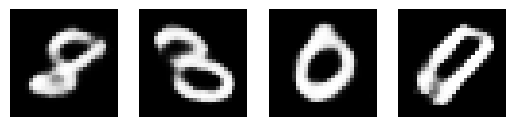

In [ ]:
a = z_prueba[prueba.targets==8][0]
b = z_prueba[prueba.targets==3][0]
c = z_prueba[prueba.targets==0][0]
comb = a - b + c

with th.no_grad():
  xa = vae.dec(a)
  xb = vae.dec(b)
  xc = vae.dec(c)
  xcomb = vae.dec(comb)

img_a = np.floor(xa.numpy().reshape(28, 28) * 127.5 + 127.5)
img_b = np.floor(xb.numpy().reshape(28, 28) * 127.5 + 127.5)
img_c = np.floor(xc.numpy().reshape(28, 28) * 127.5 + 127.5)
img_comb = np.floor(xcomb.numpy().reshape(28, 28) * 127.5 + 127.5)

ax = plt.subplot(1, 4, 1)
ax.imshow(img_a, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 2)
ax.imshow(img_b, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 3)
ax.imshow(img_c, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 4)
ax.imshow(img_comb, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')